<a href="https://colab.research.google.com/github/JCherryA050/phase_4_project/blob/main/phase_4_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Anime List Recommendation System With ALS

## Business Problem

My Anime List is a website where users can track and rate the anime and manga that they consume. Using this information, My Anime List has a global ranking of anime/manga, has a recommendation system based on users preferences, and directs users to where they can watch or read a given anime/manga.

We have been tasked with taking user data specifically dealing with anime to find out if we can create a more effective recommendation system using Alternating Least Squares (ALS) and Singular Value Decomposition (SVD)

## Setting Up Environment and Data

Because ALS relies on a sparse matrix of data (even when cleaning the data to reduce the size), we will be taking advantage Google's cloud service Colab, which will allow us to process an extremely large dataset. Google Colab will also allow us to utilize PySpark, a tool for ALS models.

To start, we will run the following to set up our Google Colab environment.

To compare the ALS model we decided to use models from surprise. We need to run the following code to install the surprise package into Google Colab.

In [ ]:
# Run for Google Colab environment
!pip install pyspark
!pip install openjdk-8-jdk-headless -qq
!pip install mlflow

# Surprise is not downloaded in Google Colab instance so we have to download the packages first
!pip install surprise

ERROR: Could not find a version that satisfies the requirement openjdk-8-jdk-headless (from versions: none)
ERROR: No matching distribution found for openjdk-8-jdk-headless


  Using cached mlflow-1.19.0-py3-none-any.whl (14.4 MB)
Processing c:\users\ajche\appdata\local\pip\cache\wheels\e9\f3\dc\eeff77dbc147629fa716741fc216520abbc0e15ce4b876706f\databricks_cli-0.14.3-py3-none-any.whl
Processing c:\users\ajche\appdata\local\pip\cache\wheels\69\6f\b4\2087abb1172ae32c58e366dc09746de46a72b0e9fb2c022920\prometheus_flask_exporter-0.18.2-py3-none-any.whl
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached Flask-2.0.1-py3-none-any.whl (94 kB)
  Using cached sqlparse-0.4.1-py3-none-any.whl (42 kB)
  Using cached GitPython-3.1.18-py3-none-any.whl (170 kB)
Processing c:\users\ajche\appdata\local\pip\cache\wheels\9d\de\6d\ca8d461ec29e010b1267d7353d0b058819770f7680bb9360e4\alembic-1.4.1-py2.py3-none-any.whl
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached Werkzeug-2.0.1-py3-none-any.whl (288 kB)
  Using cached Jinja2-3.0.1-py3-none-any.whl (133 kB)
  Using cac

Now that we have installed everything  we will import the following libraries for PySpark, and set up a spark session. We will also import the relevant functions from the surprise library for testing other models.

Following that, we will remove some data from our data. We are going to avoid Hentai recommendations from now, and want to ensure that we use full length shows or movies, so if an anime duration is in seconds we will remove it.
 


In [ ]:
# import standard packages
import pandas as pd
import numpy as np


# Import the relevant packages for pyspark
import pyspark
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import feature
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
# import org.apache.spark.sql.functions.col
# import org.apache.spark.sql.types.IntegerType
# import pyspark.sql.functions.col
from pyspark.sql.types import IntegerType

# Import relevant packages for surprise
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

# import standard packages for plotting
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('fivethirtyeight')

#Ignore warnings in cells
import warnings
warnings.filterwarnings('ignore')

# Setting random seed to 1 for reproducability
import random
random.seed(1)

### Loading the Data

If you are running this code on Google Colab, please upload the data to the directories and use the second data path defined below. The data is not included in the repo, if running the code locally please crease a data folder in the repo and extract the data from [here](https://www.kaggle.com/hernan4444/anime-recommendation-database-2020) into the folder and use the first data path below.

The Data is subsampled with 1000 samples to facilitate running the code for submission. If running this code in Google Colab it is recommended raise this number.

In [ ]:
# Import all related data sets

# Defining the path to the data
data_path = './data/'
# Path to the data if running code in Google Colab
# data_path = ''

anime_df = pd.read_csv(data_path+'anime.csv')
anime_list_df = pd.read_csv(data_path+'animelist.csv')
# anime_with_sin_df = pd.read_csv('./data/anime_with_synopsis.csv')
# rating_comp_df = pd.read_csv('./data/rating_complete.csv')
# watch_stat_df = pd.read_csv('./data/watching_status.csv')

In [ ]:
# dropping all of the anime of ill repute
anime_df = anime_df[~anime_df['Genres'].str.contains("Hentai")]

# dropping all of the anime with air rimes less than 1 sec.
anime_df = anime_df[~anime_df['Duration'].str.contains("sec")]

# Remove types of anime that fall outside of the scope
anime_df = anime_df[~anime_df['Type'].str.contains('|'.join(['Movie','Music', 'OVA', 'Special', 'ONA', 'Unknown']))]

# Filter out anime before 1980
# anime_df = anime_df[anime_df['Premiered'] >= 1980]

# using the ID of the cleaned anime list to clean the list of ratings as well
anime_list_df = anime_list_df[anime_list_df['anime_id'].isin(list(anime_df['MAL_ID'].tolist()))]

# Cutting all of the reviews of 0
anime_list_df = anime_list_df[anime_list_df['rating'] != 0]

# There is way too much data in this set so we will be resampling the data to 
# make a smaller data set.
anime_list_df = anime_list_df.sample(1000,random_state=1)

## EDA

We start by looking at some of the features of the anime and the ratings data. We look at the distribution of ratings and the distributions of the rating count per user and anime title.

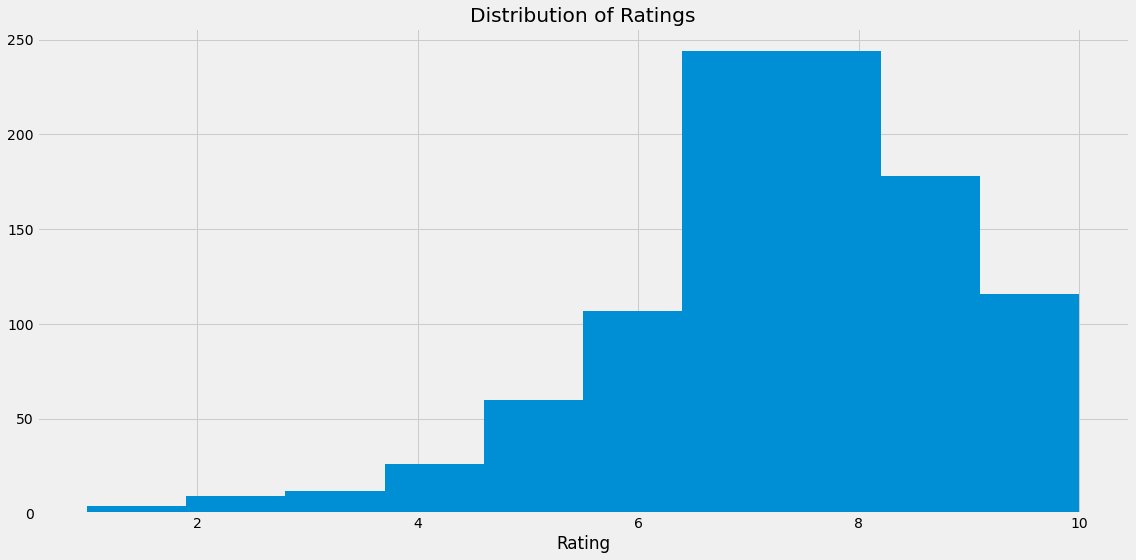

In [ ]:
# Plotting the distribution of the ratings to show the small tail issue
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(anime_list_df['rating'], bins=10)
ax.set_title('Distribution of Ratings')
ax.set_xlabel('Rating')
plt.tight_layout()

#Save fig
fig.savefig('./imgs/rating_dist.png');

In [ ]:
# Look at the mean and standard deviation of the ratings to compare the RMSE of our models
ave = anime_list_df[anime_list_df['rating'] != 0]['rating'].mean()
stdev = anime_list_df[anime_list_df['rating'] != 0]['rating'].std()
print("Average Ratings: ",ave)
print("Standard Dev. of Ratings: ",stdev)

Average Ratings:  7.526
Standard Dev. of Ratings:  1.693573792957423


### Looking at the Genres of Anime

In [ ]:
# Drop uneccesary columnsastype
genres = anime_df['Genres'].str.split(', ')

In [ ]:
# Generating a dictionary of the genres and their respective count
genres_dict = {}
for row in genres:
  for i in row:
    i.replace(',','')
    if i in genres_dict.keys():
      genres_dict[i] += 1
    else:
      genres_dict[i] = 0

In [ ]:
# if word cloud is not already installed run the commented code below
# !pip install wordcloud

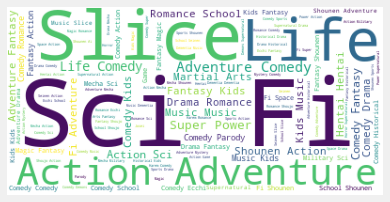

In [ ]:
# Create a text box of all of the genres
lst = []
for i in genres:
    lst += i
all_genres = ' '.join(lst)

# Create the wordcloud object
wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(all_genres)

# Plotting the frequency of genres in a wordcloud
fig,ax = plt.subplots()
plt.imshow(wordcloud, interpolation=None)
plt.axis("off")
plt.show()
fig.savefig('./imgs/genres_cloud.png');

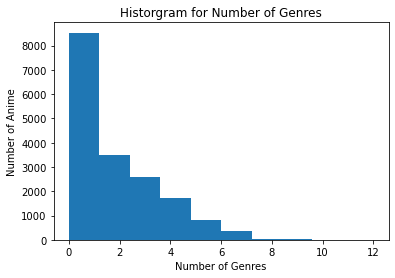

In [ ]:
# Plot a histogram of the number of genres per anime title
fig, ax = plt.subplots()

plt.hist(anime_info['genre_count'])
plt.title('Historgram for Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Number of Anime');
plt.tight_layout()

fig.savefig('./imgs/dist_number_genre.png')


### Looking at the year premeired

In [ ]:
# Create a function to split the Premiered values and grab the year from the column
def split_and_take_min(x):
    # split each value
    lst = x.split(' ')
    nums = []
    # grab the years from the values and return the first year in the value
    for i in lst:
        try:
            nums.append(int(i))
        except:
            continue
    try:
        return int(nums[0])
    except:
        return 0
# Apply the function the the Premeired column in the data
anime_df['Premiered'] = anime_df['Premiered'].apply(split_and_take_min)    

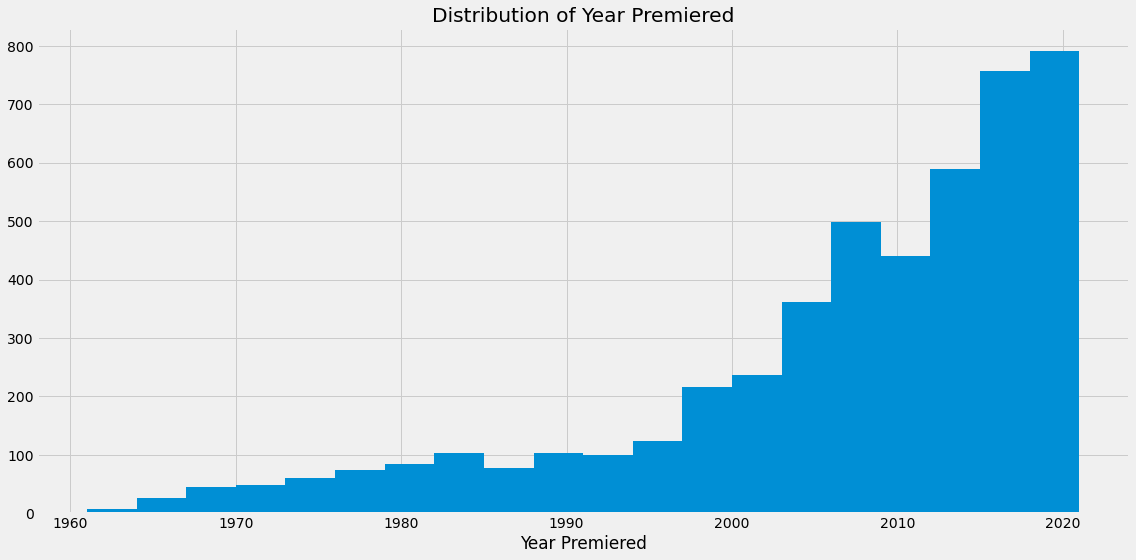

In [ ]:
# Grab the non-zero years from the Premeiered column
years = list(anime_df[anime_df['Premiered'] != 0]['Premiered'])

# plot the distribution of years premiered to show the growing market
fig,ax = plt.subplots(figsize=(16,8))
ax.hist(years,bins=20)
ax.set_title('Distribution of Year Premiered')
ax.set_xlabel('Year Premiered')
plt.tight_layout()

fig.savefig('./imgs/dist_year_premiered.png')

### Looking at the number of items and number of users in the ratings dataset

In [ ]:
# Looking at the number of users and the number of items in the rankings dataset
user_num = anime_list_df['user_id'].value_counts().shape[0]
item_num = anime_list_df['anime_id'].value_counts().shape[0]


In [ ]:
# print out the numbers in a table
print('Number of users: ', user_num, '\n')
print('Number of items: ', item_num)


Number of users:  994 

Number of items:  680


|||
|:------|:-------|
|Users|325176|
|Items|15780|

- There are significantly more users than items. We'll take that into account when inputting the specifications to our similarity metrics. Because we have fewer items than users, it will be more efficient to calculate item-item similarity rather than user-user similarity

### Looking at the numbers of different producers, genres, Licensors, Studios

In [ ]:
# Pull the number of producers, studios, and titles of animes premiering in 2020
num_producers_2020 = anime_df[anime_df['Premiered'] == 2020]['Producers'].value_counts().shape[0]
num_Studio_2020 = anime_df[anime_df['Premiered'] == 2020]['Studios'].value_counts().shape[0]
num_Title_2020 = anime_df[anime_df['Premiered'] == 2020]['Name'].value_counts().shape[0]

print('Producers in 2020: ',num_producers_2020)
print('Studios in 2020: ',num_Studio_2020)
print('Titles in 2020: ',num_Title_2020)

Producers in 2020:  123
Studios in 2020:  109
Titles in 2020:  191


In [ ]:
# Pull the number of producers, studios, and titles of animes premiering in 2000
num_producers_2000 = anime_df[anime_df['Premiered'] == 2000]['Producers'].value_counts().shape[0]
num_Studio_2000 = anime_df[anime_df['Premiered'] == 2000]['Studios'].value_counts().shape[0]
num_Title_2000 = anime_df[anime_df['Premiered'] == 2000]['Name'].value_counts().shape[0]

print('Producers in 2000: ',num_producers_2000)
print('Studios in 2000: ',num_Studio_2000)
print('Titles in 2000: ',num_Title_2000)

Producers in 2000:  42
Studios in 2000:  28
Titles in 2000:  57


### Considering number of reviews per anime and user

In [ ]:
# group the data set by anime IDaggregating the count and plotting a bar graph of the number per ID
anime_review_count = anime_list_df.groupby('anime_id').count()

# Sort the grouped id's by the number of reviews for each
anime_review_count_sorted = anime_review_count.sort_values('rating',ascending=False)


# pull the top 20 most rated anime in the set
most_reviewed = list(anime_review_count_sorted.index)[:20]

# Matching tthe top 20 most reviewed anime with their title and average score
most_review_titles = []
for item in most_reviewed:
    name = anime_df.loc[anime_df['MAL_ID']==item,['Name']].values[0][0]
    num = anime_review_count_sorted.loc[item,['rating']].values[0]
    rate = anime_df.loc[anime_df['MAL_ID']==item,['Score']].values[0][0]
    most_review_titles.append( (name,num,rate) )
    

# Put the results into a DataFrame and viewing the results
most_review_titles_df = pd.DataFrame(most_review_titles,columns=['Name','N ratings','Ave. Rating'])
most_review_titles_df

,Name,N ratings,Ave. Rating
0,Death Note,7,8.63
1,Sword Art Online,6,7.25
2,Shigatsu wa Kimi no Uso,6,8.74
3,Chuunibyou demo Koi ga Shitai!,6,7.77
4,Soul Eater,5,7.88
5,Tokyo Ghoul,5,7.81
6,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,5,8.42
7,Haikyuu!!,5,8.53
8,Kimi ni Todoke,5,8.02
9,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa G...,4,8.87


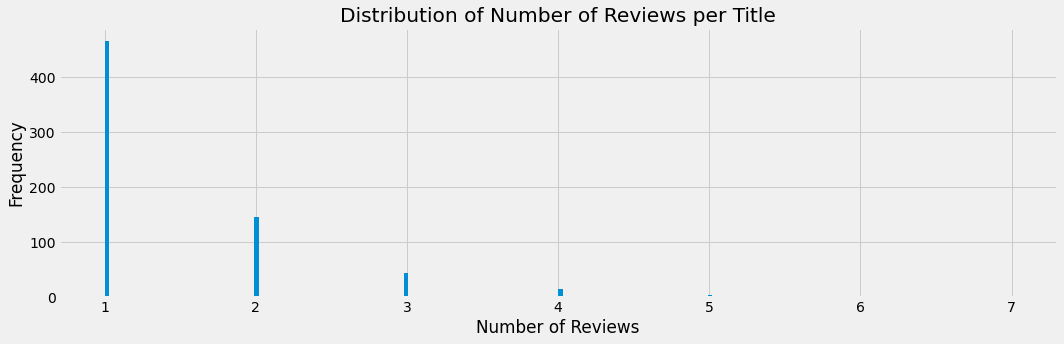

In [ ]:
# Plotting the full distribution of number of reviews per anime title
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(anime_review_count_sorted.rating,bins=200);
ax.set_title("Distribution of Number of Reviews per Title")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel('Frequency')
plt.tight_layout()

fig.savefig('./imgs/dist_review_count.png')


In [ ]:
# Group the ratings data by user and plot the distribution of ratings per user
user_review_count = anime_list_df.groupby('user_id').count()

# Sort the grouped data by the number of reviews per user
user_review_count_sorted = user_review_count.sort_values('rating',ascending=False)

# pull the top 5 users with the highes number of ratings given
most_review_user = list(user_review_count_sorted.index)[:5]

# Matching the top 5 users giving the most reviews with thier respective id's
most_review = []
for item in most_review_user:
    name = item
    num = user_review_count_sorted.loc[item,['rating']].values[0]
    most_review.append( (name,num) )

# Put the results into a DataFrame and viewing the results
most_review_user_df = pd.DataFrame(most_review,columns=['User ID','N ratings'])
most_review_user_df

,User ID,N ratings
0,135198,2
1,178361,2
2,70128,2
3,60206,2
4,142616,2


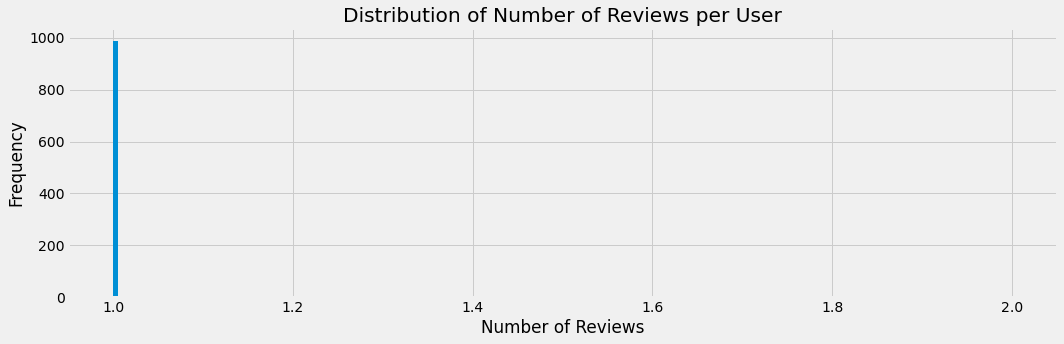

In [ ]:
# Plotting the distribution of users by the number of ratings per user
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(user_review_count.rating,bins=200);
ax.set_title("Distribution of Number of Reviews per User")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel('Frequency')
plt.tight_layout()

fig.savefig('./imgs/dist_user_review_count.png')

## Building Our ALS Model

Next, we are going to create a spark dataframe for our user recommendation data. We only want ratings, user id, and anime id. Because the dataset is already pretty large, we want to drop anything we can, so we can get rid of watched_status and watched_episodes. Additonally, we need to make sure all of our remaining values are integers.

Note: If you are also using Google Colab, you will need to make sure to upload any CSVs in the colab instance.

In [ ]:
# initialize a Spark Session setting app name and host
spark = SparkSession\
        .builder\
        .appName('anime_rec').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [ ]:
# Create the Spark dataframe
rec_data = spark.createDataFrame(cleaned_df)

In [ ]:
# Change the data types in the dataframe to Integer
rec_data = rec_data.withColumn('rating', rec_data['rating'].cast(IntegerType()))
rec_data = rec_data.withColumn('user_id', rec_data['user_id'].cast(IntegerType()))
rec_data = rec_data.withColumn('anime_id', rec_data['anime_id'].cast(IntegerType()))

In [ ]:
# Check to see if the change took
rec_data.dtypes

[('user_id', 'int'),
 ('anime_id', 'int'),
 ('rating', 'int'),
 ('watching_status', 'bigint'),
 ('watched_episodes', 'bigint')]

In [ ]:
# Drop the unnecessary columns from the data
rec_data = rec_data.drop('watching_status')
rec_data = rec_data.drop('watched_episodes')

Now that everything is set up, we can do a train test split and build a model. Our first model will make some guesses for our parameters, and from there we can try tweaking things a bit.

In [ ]:
(training, test) = rec_data.randomSplit([0.8, 0.2], seed=1)

als = ALS(userCol='user_id', itemCol='anime_id', ratingCol='rating', coldStartStrategy ='drop', nonnegative= True, implicitPrefs=True)


In [ ]:
params = ParamGridBuilder()\
  .addGrid(als.regParam, [0.1, 0.2])\
  .addGrid(als.maxIter, [20])\
  .addGrid(als.rank, [15]).build() # Ran earlier and found 10 to be best

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

tvs = TrainValidationSplit(estimator=als,
                    estimatorParamMaps=params,
                    evaluator=evaluator)

In [ ]:
model = tvs.fit(training)

best_model = model.bestModel

In [ ]:
# We see the best model has a rank of 10, so we will use that in our future models with this dataset
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)

print('RMSE = ' + str(rmse))
print('---Best Model---')
print(' Rank:', best_model.rank) 
print(' MaxIter:', best_model._java_obj.parent().getMaxIter())
print(' RegParam:', best_model._java_obj.parent().getRegParam())

RMSE = 5.731110336044163
---Best Model---
 Rank: 15
 MaxIter: 20
 RegParam: 0.2


### Matching IDs to Names

Now that we have a model with more dependable scores, we need to be a bit user friendly. It is not very helpful to recommend anime_id 1 to a user, rather than Cowboy Bepop!

We are going to pull in our data set with anime information and write a function to get the title.

In [ ]:
anime_titles = spark.read.csv('anime.csv', header=True)
anime_titles.head(5)

[Row(MAL_ID='1', Name='Cowboy Bebop', Score='8.78', Genders='Action, Adventure, Comedy, Drama, Sci-Fi, Space', English name='Cowboy Bebop', Japanese name='カウボーイビバップ', Type='TV', Episodes='26', Aired='Apr 3, 1998 to Apr 24, 1999', Premiered='Spring 1998', Producers='Bandai Visual', Licensors='Funimation, Bandai Entertainment', Studios='Sunrise', Source='Original', Duration='24 min. per ep.', Rating='R - 17+ (violence & profanity)', Ranked='28.0', Popularity='39', Members='1251960', Favorites='61971', Watching='105808', Completed='718161', On-Hold='71513', Dropped='26678', Plan to Watch='329800', Score-10='229170.0', Score-9='182126.0', Score-8='131625.0', Score-7='62330.0', Score-6='20688.0', Score-5='8904.0', Score-4='3184.0', Score-3='1357.0', Score-2='741.0', Score-1='1580.0'),
 Row(MAL_ID='5', Name='Cowboy Bebop: Tengoku no Tobira', Score='8.39', Genders='Action, Drama, Mystery, Sci-Fi, Space', English name='Cowboy Bebop:The Movie', Japanese name='カウボーイビバップ 天国の扉', Type='Movie', Epis

In [ ]:
def name_retriever(anime_id, dataframe=anime_titles):
    name = anime_titles.where(anime_titles.MAL_ID == anime_id).take(1)[0]['English name']
    # If there is no English name available
    if name == 'Unknown':
      name = anime_titles.where(anime_titles.MAL_ID == anime_id).take(1)[0]['Name']
    return name

In [ ]:
print(name_retriever(1, anime_titles))

Cowboy Bebop


### Getting Recommendations

We are going to go ahead and pull recommendations for users. Spark actually already has built in functions to get recommendations called recommendForUserSubset. There is also a more general function called recommendForAllUsers.

In [ ]:
users = rec_data.select(als.getUserCol()).distinct().limit(10)
userSubsetRecs = best_model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [ ]:
recs

[Row(user_id=109050, recommendations=[Row(anime_id=1575, rating=0.5800600647926331), Row(anime_id=20, rating=0.557708203792572), Row(anime_id=19815, rating=0.5254242420196533), Row(anime_id=4224, rating=0.5145238041877747), Row(anime_id=23273, rating=0.5140708684921265), Row(anime_id=11061, rating=0.5120140314102173), Row(anime_id=20507, rating=0.5088703036308289), Row(anime_id=25777, rating=0.4907777011394501), Row(anime_id=10620, rating=0.489093542098999), Row(anime_id=8074, rating=0.48525917530059814)])]

In [ ]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,anime_titles)

'Code Geass:Lelouch of the Rebellion'

In [ ]:
recommendations = best_model.recommendForAllUsers(5)
recommendations.where(recommendations.user_id == 7340).collect()

[Row(user_id=7340, recommendations=[Row(anime_id=5081, rating=0.7071511149406433), Row(anime_id=226, rating=0.7050871849060059), Row(anime_id=2167, rating=0.6992486119270325), Row(anime_id=9756, rating=0.6958047151565552), Row(anime_id=14741, rating=0.6565090417861938)])]

We can also set up a function for creating a new user getting and recommendations for them based on review scores we input for them. We can put the same scores into Anime Planet, and see how our recommendations compare to theirs!

In [ ]:
def new_user_recs(user_id, new_ratings, rating_df, anime_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings, rating_df.columns)
    
    # combine the new ratings df with the rating_df
    anime_ratings_combined = rating_df.union(new_user_ratings)
    
    # create an ALS model and fit it
    als = ALS(maxIter=15, rank=15, regParam=0.2, userCol='user_id', itemCol='anime_id', ratingCol='rating', coldStartStrategy='drop')
    model = als.fit(anime_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)

    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.user_id == user_id).take(1)

    for ranking, (anime_id, rating) in enumerate(recs_for_user[0]['recommendations']):
      anime_string = name_retriever(anime_id, anime_title_df)
      print('Recommendation {}: {}  | predicted score: {}'.format(ranking+1, anime_string, round(rating)))

To do a sanity check, I will enter myself as a user and with some anime rankings and get 10 recommendations for myself. We can investigate the recommendations to see if they make sense, and make adjustments based on our findings.

In [ ]:
user_id = 1000000
user_ratings_1 = [(user_id,1,7), # Cowboy Bepop
                  (user_id,2,7), # Trigun
                  (user_id,30,10), # Neon Genesis Evangelion
                  (user_id,32937,10), # KonoSuba 2
                  (user_id,22199,5), # Akame ga Kill!
                  (user_id,18679,8), # Kill la Kill
                  (user_id, 28121, 1)] # Is It Wrong to Pick Up Girls in a Dungeon?


In [ ]:
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=rec_data,
             anime_title_df=anime_titles,
             num_recs = 10)

Recommendation 1: Neon Genesis Evangelion  | predicted score: 10
Recommendation 2: Kaguya-sama:Love is War Season 2  | predicted score: 9
Recommendation 3: Owarimonogatari Second Season  | predicted score: 9
Recommendation 4: Kaguya-sama:Love is War  | predicted score: 9
Recommendation 5: Gintama.:Silver Soul Arc - Second Half War  | predicted score: 9
Recommendation 6: Attack on Titan Season 3 Part 2  | predicted score: 9
Recommendation 7: JoJo's Bizarre Adventure:Diamond is Unbreakable  | predicted score: 9
Recommendation 8: Grand Blue Dreaming  | predicted score: 9
Recommendation 9: Bakemonogatari  | predicted score: 9
Recommendation 10: KonoSuba:God's Blessing on This Wonderful World! 2  | predicted score: 9


## Building Our Surprise Models

In [ ]:
# Need to drop all of the unnecessary columns from the DataFrame
anime_list_df.drop(['watching_status','watched_episodes'],axis=1,inplace=True)

In [ ]:
# Loading in the DataFrame as a surprise objet
reader = Reader()
data = Dataset.load_from_df(anime_list_df,reader)

In [ ]:
# Looking at how many users and items are in the data to determine whether we 
# use a user-user or item-item similarity method
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  994 

Number of items:  680


Looks like there are vastly more items than there are users here so if we are using a neighborhood-based model we will evaluate with a item-item approach

### First simple models with SVD, KNNBasic, and KNNBaseline


In [ ]:
# Splitting the data into train/test sets we will be using 80% of the data to
# train the model and 20% for validating the model.
trainset,testset = train_test_split(data,test_size=0.2)

In [ ]:
# Instantiating the models

#SVD
svd = SVD(n_factors=50,reg_all=0.05)

# KNNBasic
knn_basic = KNNBasic(sim_options  = {'name':'pearson', 'user_based':False})

# KNNBaseline
knn_baseline = KNNBaseline(sim_options = {'name':'pearson', 'user_based':False})

#### SVD


In [ ]:
# Run cross validation on the data
cv_svd = cross_validate(svd,data,n_jobs=-1)

In [ ]:
# Printing out the test metrics of the cross validation for comparison
for i in cv_svd.items():
    print(i)
print('-----------------------')
print(np.mean(cv_svd['test_rmse']))

('test_rmse', array([3.082207  , 2.94023809, 2.90774827, 3.05614136, 3.20780299]))
('test_mae', array([2.75 , 2.625, 2.555, 2.72 , 2.91 ]))
('fit_time', (0.046961307525634766, 0.04896116256713867, 0.05899643898010254, 0.05599713325500488, 0.0500032901763916))
('test_time', (0.0009996891021728516, 0.002002239227294922, 0.002998828887939453, 0.0019989013671875, 0.0019953250885009766))
-----------------------
3.0388275402496747


#### KNNBasic

In [ ]:
# Run cross validation on the data 
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [ ]:
# Printing out the test metrics of the cross validation for comparison
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([3.03315018, 3.03562185, 3.00749065, 3.01247407, 3.1136795 ]))
('test_mae', array([2.72 , 2.685, 2.685, 2.685, 2.785]))
('fit_time', (0.017998695373535156, 0.014999628067016602, 0.013001203536987305, 0.016996145248413086, 0.016996383666992188))
('test_time', (0.00299835205078125, 0.0019981861114501953, 0.0019969940185546875, 0.003000020980834961, 0.003000020980834961))
-----------------------
3.0404832469967418


#### KNNBaseline

In [ ]:
# Run cross validation on the data  
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs=-1)

In [ ]:
# Printing out the test metrics of the cross validation for comparison
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([3.10724959, 3.14165561, 2.93768616, 3.02241625, 2.98998328]))
('test_mae', array([2.845, 2.8  , 2.6  , 2.665, 2.65 ]))
('fit_time', (0.024007558822631836, 0.020999431610107422, 0.021000146865844727, 0.021010398864746094, 0.02200007438659668))
('test_time', (0.002007722854614258, 0.003011465072631836, 0.0030126571655273438, 0.002988576889038086, 0.0019991397857666016))
-----------------------
3.0397981791878483


### Optimizing the best FSM (SVD)

In [ ]:
# Setting up and running the Grid Search to find the best hyperparams for the 
# svd

params = {'n_factors': [5, 10, 20, 50],
          'reg_all': [0.3, 0.5, 0.7],
          'lr_all':[0.01],
          'init_mean':[0,1,5],
          'init_std_dev':[0.05,0.1,0.5]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [ ]:
# Printing out the best parameters based on the Grid Search
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 3.0400226385620956, 'mae': 2.712}
{'rmse': {'n_factors': 5, 'reg_all': 0.3, 'lr_all': 0.01, 'init_mean': 0, 'init_std_dev': 0.05}, 'mae': {'n_factors': 5, 'reg_all': 0.3, 'lr_all': 0.01, 'init_mean': 0, 'init_std_dev': 0.05}}


### Making Recommendations


In [ ]:
# Instantiating the best model for predictions
best_model = SVD(n_factors = 50, 
                 reg_all = 0.02, 
                 lr_all = 0.01, 
                 n_epochs = 30)
best_model.fit(trainset)

In [ ]:
#Quick Prediction to see if the model is working
best_model.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=5, details={'was_impossible': False})

## Obtain the User Ratings

This function can be used to obtain user ratings when run. We have predefined user ratings that we define below for our recommendations.

In [ ]:
# Function rating the movies based on the best model
# def movie_rater(movie_df,num, genre=None):
#     userID = 1000000
#     rating_list = []
#     while num > 0:
#         if genre:
#             movie = movie_df[movie_df['Genders'].str.contains(genre)].sample(1)['Name']
#         else:
#             movie = movie_df.sample(1)['Name']
#         print(movie)
#         rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
#         if rating == 'n':
#             continue
#         else:
#             rating_one_movie = {'user_id':userID,'anime_id':movie['MAL_ID'].values[0],'rating':rating}
#             rating_list.append(rating_one_movie) 
#             num -= 1
#     return rating_list      

In [ ]:
# user_rating = movie_rater(anime_df,4,'Action')

In [ ]:
# Predefined user ratings for recommendations
user_rating = [{'anime_id': 2, 'rating': '7', 'user_id': 1000000},
               {'anime_id': 30, 'rating': '10', 'user_id': 1000000},
               {'anime_id': 32937, 'rating': '10', 'user_id': 1000000},
               {'anime_id': 22199, 'rating': '5', 'user_id': 1000000},
               {'anime_id': 18679, 'rating': '8', 'user_id': 1000000},
               {'anime_id': 28121, 'rating': '1', 'user_id': 1000000}]


In [ ]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = anime_list_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

### Make Predictions

In [ ]:
# make predictions for the user
list_of_anime = []
for m_id in anime_list_df['anime_id'].unique():
    list_of_anime.append( (m_id,best_model.predict(1000,m_id)[3]))

In [ ]:
# order the predictions from highest to lowest rated
ranked_anime = sorted(list_of_anime, key=lambda x:x[1], reverse=True)

In [ ]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,anime_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = anime_title_df.loc[anime_title_df['MAL_ID'] == int(rec[0])]['Name']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break

recommended_movies(ranked_anime,anime_df,10)

Recommendation #  1 :  16878    Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...
Name: Name, dtype: object 

Recommendation #  2 :  8625    Akame ga Kill!
Name: Name, dtype: object 

Recommendation #  3 :  8302    SoniAni: Super Sonico The Animation
Name: Name, dtype: object 

Recommendation #  4 :  5238    Kuragehime
Name: Name, dtype: object 

Recommendation #  5 :  7880    Gingitsune
Name: Name, dtype: object 

Recommendation #  6 :  15043    Dorohedoro
Name: Name, dtype: object 

Recommendation #  7 :  15037    Darwin's Game
Name: Name, dtype: object 

Recommendation #  8 :  1393    Death Note
Name: Name, dtype: object 

Recommendation #  9 :  13097    Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu ...
Name: Name, dtype: object 

Recommendation #  10 :  11    One Piece
Name: Name, dtype: object 



# Results

From ALS model, RMSE is around 5.6.
From SVD model, RMSE is around 3.1, which is better judging by the number.

## Example of results from SVD model:
We add a new user which some preference.
![table1](./imgs/input.png)

Here are 5 examples out of the total 10 recommended anime.
1. Code Geass: Hangyaku no Lelouch R2
2. Major S6
3. Death Note
4. One Punch Man
5. Black Lagoon: The Second Barrage

From 10 recommended results, we have found that 4 of them are already seen and liked; 2 of them are recommended by other services; 1 is new but recommended by friends; and 3 of them are never heard but promising.

# Conclusions

- SVD model does the best job with 3.1 RMSE.
- We are satisfied with the results so far.

# Next Steps

In order to improve results, we might need to break down the data even more. Some anime in the dataset has multiple seasons. Combining them might give a better RMSE score. 